#  [**Just Relax It**](https://github.com/intsystems/discrete-variables-relaxation) Demo Сode

In this notebook, we demonstrate how the methods from the **Just Relax It** library work.

> Before you start experimenting with the library, you need to install all the necessary dependencies, follow the instruction in the `README.md`.

In the **Just Relax It** library, the implemented distributions have a similar structure, so we chose one distribution for demonstration and conducted a number of experiments with it. [**Correlated Relaxed Bernoulli**](https://openreview.net/pdf?id=oDFvtxzPOx) was chosen as a demonstration method.
This method generates correlated gate vectors from a multivariate Bernoulli distribution using a Gaussian copula:
$$C_R(U_1, \ldots, U_p) = \Phi_R(\Phi^{-1}(U_1), \ldots, \Phi^{-1}(U_p)),
$$
where $\Phi_R$ is the joint CDF of a multivariate Gaussian distribution with correlation matrix $R$, and $\Phi^{-1}$ is the inverse CDF of the standard univariate Gaussian distribution.
The gate vector $m$ is generated as:
$$m_k =
\begin{cases}
1 & \text{if } U_k \leq \pi_k \\0 & \text{if } U_k > \pi_k
\end{cases}\quad k = 1, \ldots, p,
$$
where $U_k$ are correlated random variables preserving the input feature correlations.
For differentiability, a continuous relaxation is applied:
$$m_k = \sigma \left( \frac{1}{\tau} \left( \log \frac{U_k}{1 - U_k} + \log \frac{\pi_k}{1 - \pi_k} \right) \right),
$$
where $\sigma(x) = \frac{1}{1 + \exp(-x)}$ is the sigmoid function, and $\tau$ is a temperature hyperparameter.

The theory of other methods from **Just Relax It** library can be viewed in the [blog-post](https://github.com/intsystems/discrete-variables-relaxation/blob/main/assets/blog-post.pdf).

## Importing libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import torch
import sys
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..', 'src')))
from relaxit.distributions import CorrelatedRelaxedBernoulli

%load_ext autoreload
%autoreload 2

/home/jovyan/.mlspace/envs/nkiselev_relaxit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Simplest Examples
### Initializing distribution **Correlated Relaxed Bernoulli**

Let's define the parameters $\pi$, $R$, and $\tau$ for the demonstration:

- Tensor $\pi$, representing the probabilities of the Bernoulli distribution, with an event shape of 3 and a batch size of 2.
   $$
   \pi = \begin{bmatrix}
   0.2 & 0.4 & 0.4 \\
   0.3 & 0.5 & 0.2
   \end{bmatrix}
   $$

- Correlation matrix $R$ for the Gaussian copula.
   $$
   R = \begin{bmatrix}
   1.0 & 0.5 & 0.3 \\
   0.5 & 1.0 & 0.7 \\
   0.3 & 0.7 & 1.0
   \end{bmatrix}
   $$

- Temperature hyperparameter $\tau$.
   $$
   \tau = 0.1
   $$

In [2]:
# Define the parameters
pi = torch.tensor([[0.2, 0.4, 0.4], [0.3, 0.5, 0.2]])
R = torch.tensor([[1.0, 0.5, 0.3], [0.5, 1.0, 0.7], [0.3, 0.7, 1.0]])
tau = torch.tensor(0.1)

# Create an instance of the CorrelatedRelaxedBernoulli distribution
MyCorrelatedRelaxedBernoulli = CorrelatedRelaxedBernoulli(pi=pi, R=R, tau=tau)

### Sampling from **Correlated Relaxed Bernoulli**

In [3]:
# Example usage
torch.manual_seed(0)

sample = MyCorrelatedRelaxedBernoulli.rsample()

assert sample.shape == torch.Size([2, 3])
assert MyCorrelatedRelaxedBernoulli.log_prob(sample).shape == torch.Size([2, 3])
assert MyCorrelatedRelaxedBernoulli.batch_shape == torch.Size([2])
assert MyCorrelatedRelaxedBernoulli.event_shape == torch.Size([3])

print(f"Sampled gate vector:\n{sample}\n")
print(f"Sample log probability:\n{MyCorrelatedRelaxedBernoulli.log_prob(sample)}\n")
print(f"arg_constraints = {MyCorrelatedRelaxedBernoulli.arg_constraints}\n")
print(f"batch_shape = {MyCorrelatedRelaxedBernoulli.batch_shape}, event_shape = {MyCorrelatedRelaxedBernoulli.event_shape}")

Sampled gate vector:
tensor([[1.0000e+00, 9.8642e-01, 5.6586e-12],
        [6.7509e-01, 2.3547e-05, 2.5322e-18]])

Sample log probability:
tensor([[-30.6162, -15.8109,  -6.6164],
        [ -5.6508, -11.1152,  -0.6164]])

arg_constraints = {'pi': Interval(lower_bound=0, upper_bound=1), 'R': PositiveDefinite(), 'tau': GreaterThan(lower_bound=0.0)}

batch_shape = torch.Size([2]), event_shape = torch.Size([3])


## VAE model with a distribution **Correlated Relaxed Bernoulli**
### VAE theory
The Variational Autoencoder (VAE) consists of an encoder $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})$ and a decoder $p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z})$, both represented by neural networks. The encoder outputs parameters of a latent distribution, while the decoder outputs parameters of the sample distribution. Training a VAE involves maximizing the Evidence Lower Bound (ELBO):

$$
\mathcal{L}_{\boldsymbol{\phi}, \boldsymbol{\theta}}(\mathbf{x}) = \mathbb{E}_{q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x})} \log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z}) - KL(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \| p(\mathbf{z})) \to \max_{\boldsymbol{\phi}, \boldsymbol{\theta}}.
$$

During the M-step, the unbiased estimator for the gradient of the ELBO with respect to the decoder parameters is derived as:

$$
\nabla_{\boldsymbol{\theta}}\mathcal{L}_{\boldsymbol{\phi}, \boldsymbol{\theta}}(\mathbf{x}) \approx \nabla_{\boldsymbol{\theta}} \log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z}^*), \quad \mathbf{z}^* \sim q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}).
$$

However, during the E-step, obtaining an unbiased estimator for the gradient with respect to the encoder parameters is challenging due to the dependency of the density function on the encoder parameters. This is where the reparameterization trick is employed:

$$
\nabla_{\boldsymbol{\phi}} \int q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}) \log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{z}) d\mathbf{z} = \int p(\boldsymbol{\epsilon}) \nabla_{\boldsymbol{\phi}} \log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{g}_{\boldsymbol{\phi}}(\mathbf{x}, \boldsymbol{\epsilon})) d\boldsymbol{\epsilon} \approx \nabla_{\boldsymbol{\phi}} \log p_{\boldsymbol{\theta}}(\mathbf{x}|\mathbf{g}_{\boldsymbol{\phi}}(\mathbf{x}, \boldsymbol{\epsilon}^*)), \quad \boldsymbol{\epsilon}^* \sim p(\boldsymbol{\epsilon}).
$$

This trick is crucial for latent spaces but poses challenges for discrete representations, necessitating an analogue of the reparameterization trick for discrete distributions. Read more in [blog-post](https://github.com/intsystems/discrete-variables-relaxation/blob/main/assets/blog-post.pdf).

### VAE implementation with **Correlated Relaxed Bernoulli** distribution and Loss implementation

In [4]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) with Correlated Relaxed Bernoulli distribution.
    """
    def __init__(self, device) -> None:
        super(VAE, self).__init__()

        # Define the layers of the encoder and decoder networks
        self.fc1 = nn.Linear(784, 400)  # First fully connected layer of the encoder
        self.fc2 = nn.Linear(400, 20)   # Second fully connected layer of the encoder
        self.fc3 = nn.Linear(20, 400)   # First fully connected layer of the decoder
        self.fc4 = nn.Linear(400, 784)  # Second fully connected layer of the decoder

        # Initialize R as some symmetric positive definite matrix
        self.R = torch.eye(20, device=device)  # Identity matrix for correlation
        self.tau = torch.tensor(0.1, device=device)  # Temperature parameter for the distribution

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """
        Encode the input by passing through the encoder network
        and return the latent code.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Latent code.
        """
        h1 = F.relu(self.fc1(x))  # Apply ReLU activation to the first layer output
        return torch.sigmoid(self.fc2(h1))  # Apply sigmoid activation to the second layer output

    def decode(self, z: torch.Tensor) -> torch.Tensor:
        """
        Decode the latent code by passing through the decoder network
        and return the reconstructed input.

        Args:
            z (torch.Tensor): Latent code.

        Returns:
            torch.Tensor: Reconstructed input.
        """
        h3 = F.relu(self.fc3(z))  # Apply ReLU activation to the first layer output
        return torch.sigmoid(self.fc4(h3))  # Apply sigmoid activation to the second layer output

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the VAE.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            tuple[torch.Tensor, torch.Tensor]: Reconstructed input and latent code.
        """
        pi = self.encode(x.view(-1, 784))  # Flatten the input and encode it
        pi = torch.clamp(pi, min=1e-6, max=1-1e-6)  # Clamp the values to avoid numerical instability
        q_z = CorrelatedRelaxedBernoulli(pi, self.R, self.tau)  # Define the distribution
        z = q_z.rsample()  # Sample with reparameterization

        return self.decode(z), pi  # Decode the sampled latent code and return the reconstructed input and latent code

In [5]:
def loss_function(
    recon_x: torch.Tensor,
    x: torch.Tensor,
    q_z: torch.Tensor,
    prior: float = 0.5,
    eps: float = 1e-10
) -> torch.Tensor:
    """
    Compute the loss function for the VAE.

    Args:
        recon_x (torch.Tensor): Reconstructed input.
        x (torch.Tensor): Original input.
        q_z (torch.Tensor): Latent code.
        prior (float): Prior probability.
        eps (float): Small value to avoid log(0).

    Returns:
        torch.Tensor: Loss value.
    """
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    t1 = q_z * ((q_z + eps) / prior).log()
    t2 = (1 - q_z) * ((1 - q_z + eps) / (1 - prior)).log()
    KLD = torch.sum(t1 + t2, dim=-1).sum()

    return BCE + KLD

### Training our model on the MNIST dataset
To get started, download the dataset and initialize the dataloaders.

In [6]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

Initializing the model and parameters

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VAE(device).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

steps = 0

Write the training code

In [8]:
def train(epoch: int) -> None:
    """
    Train the VAE for one epoch.

    Args:
        epoch (int): Current epoch number.
    """
    global steps
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, q_z = model(data)
        loss = loss_function(recon_batch, data, q_z)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        steps += 1

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [ ]:
def test(epoch: int) -> None:
    """
    Test the VAE for one epoch.

    Args:
        epoch (int): Current epoch number.
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, q_z = model(data)
            test_loss += loss_function(recon_batch, data, q_z).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                       recon_batch.view(batch_size, 1, 28, 28)[:n]])
                fig, axes = plt.subplots(2, n, figsize=(n, 2))
                for j in range(n):
                    axes[0, j].imshow(data[j].cpu().squeeze(), cmap='gray')
                    axes[0, j].axis('off')
                    axes[1, j].imshow(recon_batch[j].view(1, 28, 28).cpu().squeeze(), cmap='gray')
                    axes[1, j].axis('off')
                fig.suptitle('Reconstruction')
                plt.show()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

Now let's train our model for 10 epochs

====> Epoch: 1 Average loss: 184.8177


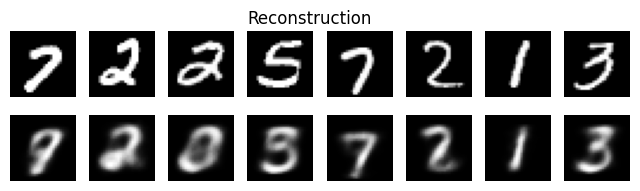

====> Test set loss: 153.7919


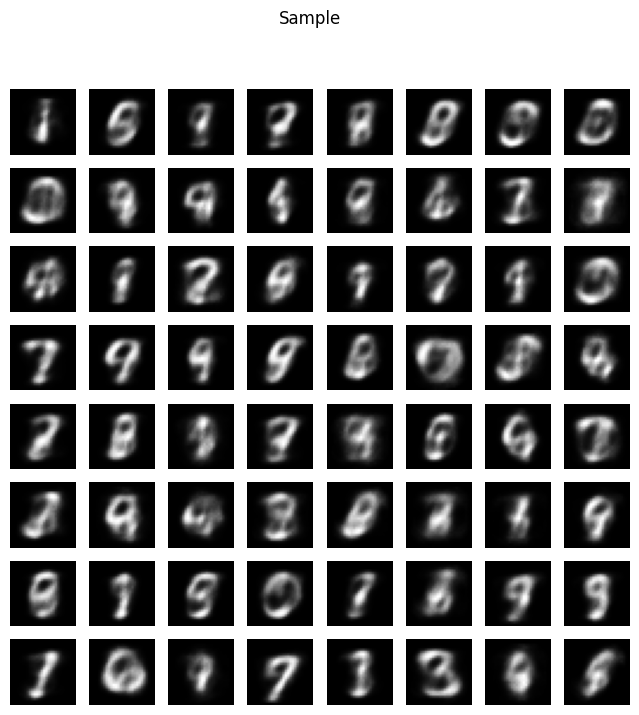

====> Epoch: 2 Average loss: 149.1349


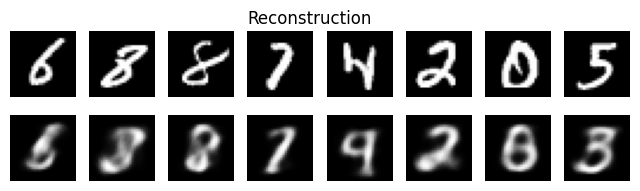

====> Test set loss: 144.4759


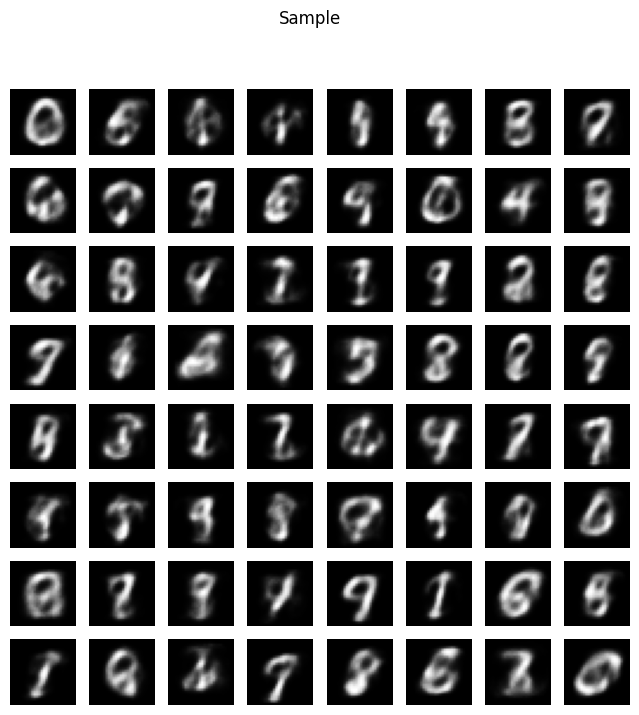

====> Epoch: 3 Average loss: 142.8365


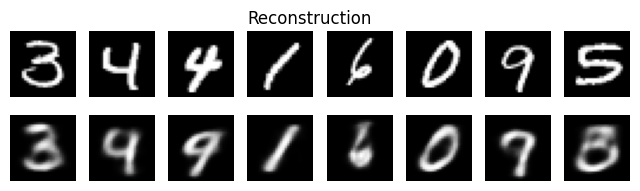

====> Test set loss: 139.8198


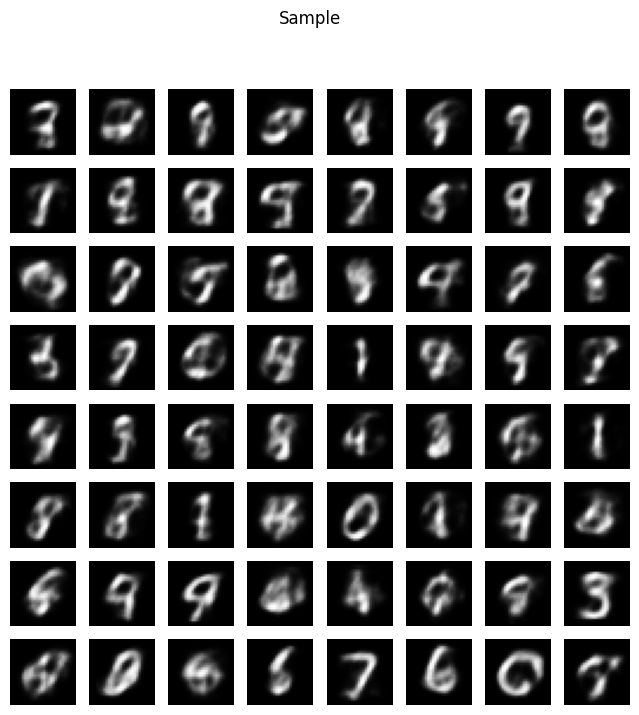

====> Epoch: 4 Average loss: 139.0856


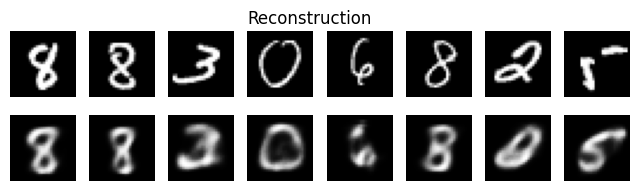

====> Test set loss: 136.4871


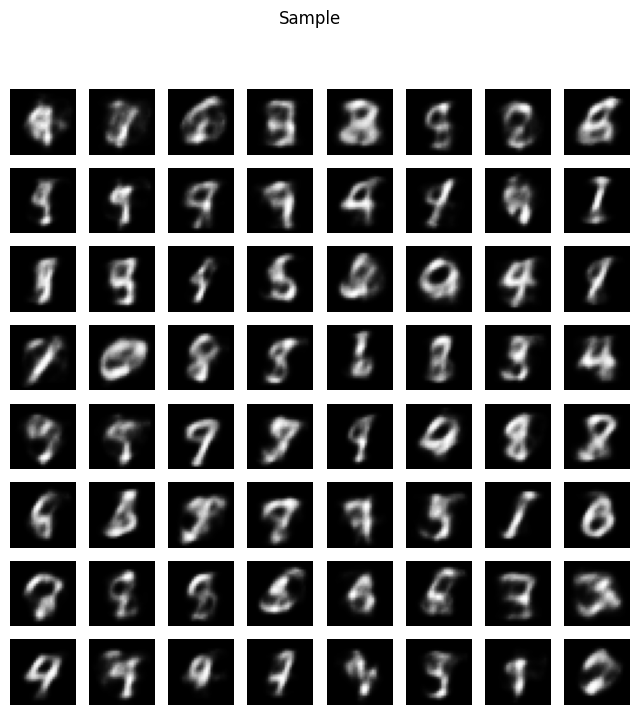

====> Epoch: 5 Average loss: 136.0520


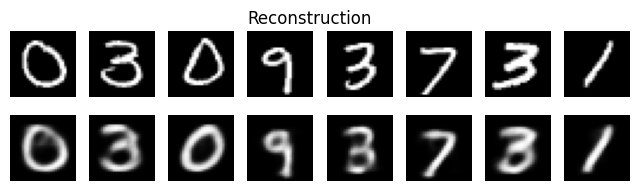

====> Test set loss: 133.9726


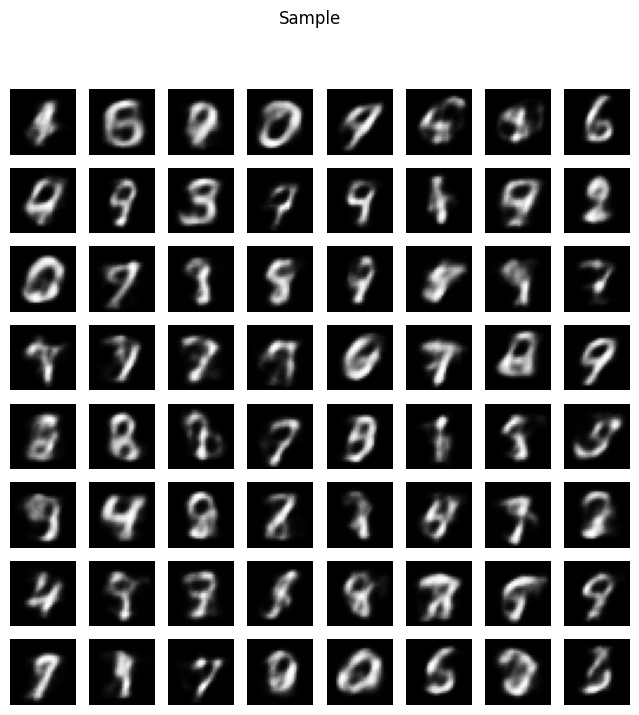

====> Epoch: 6 Average loss: 133.8150


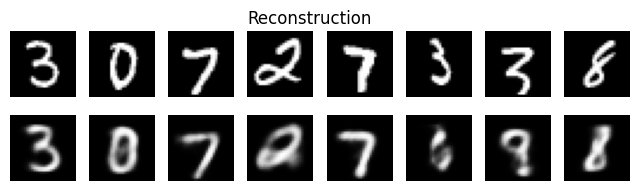

====> Test set loss: 131.6153


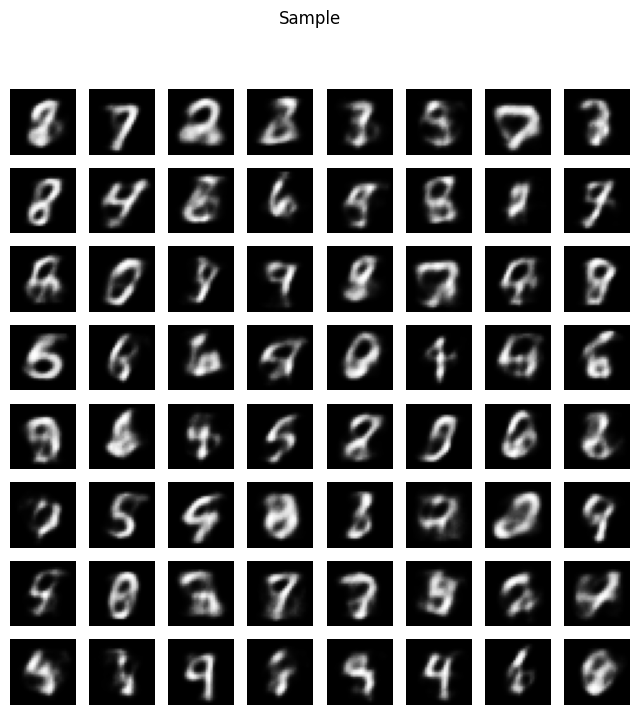

====> Epoch: 7 Average loss: 131.9898


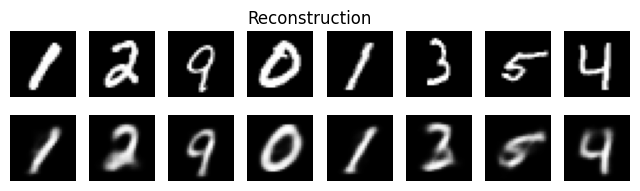

====> Test set loss: 130.3617


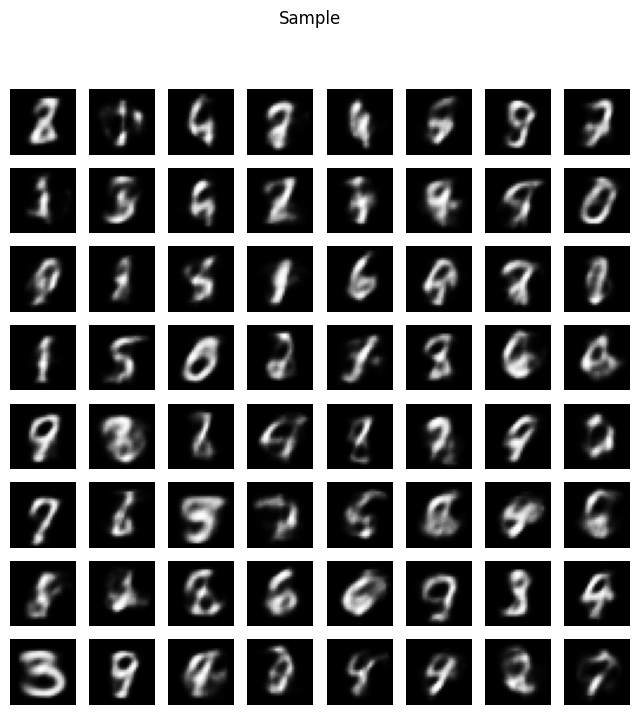

====> Epoch: 8 Average loss: 130.5765


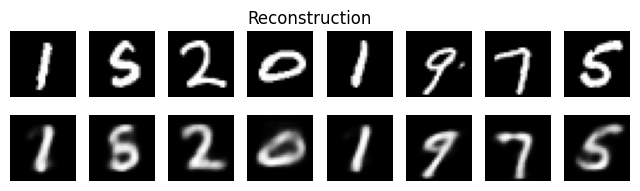

====> Test set loss: 129.2489


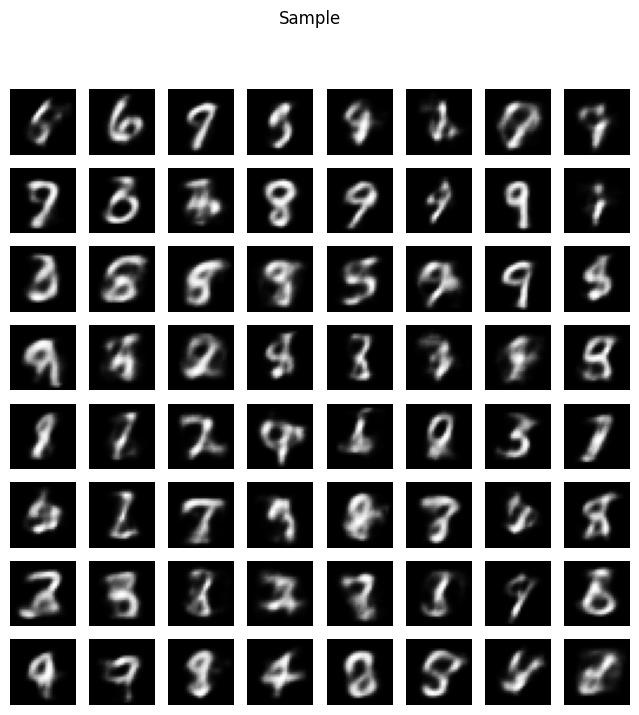

====> Epoch: 9 Average loss: 129.5105


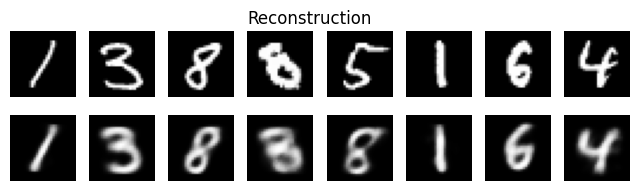

====> Test set loss: 127.9184


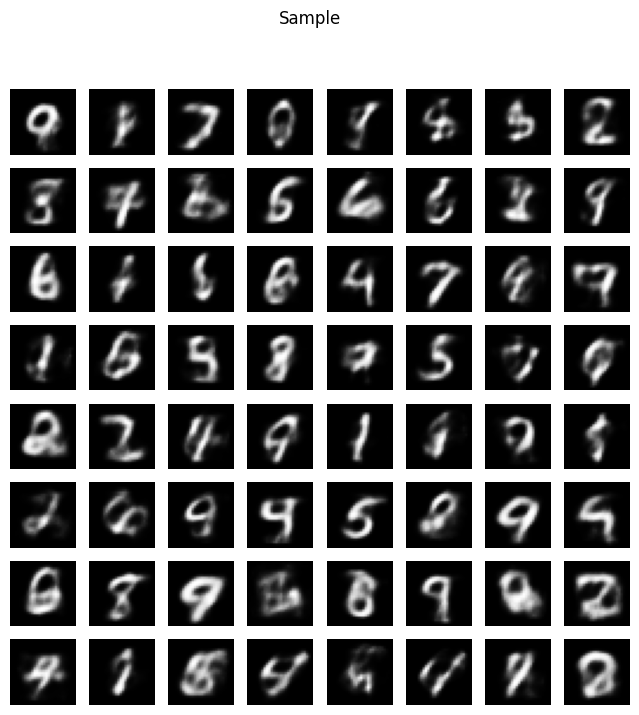

====> Epoch: 10 Average loss: 128.6162


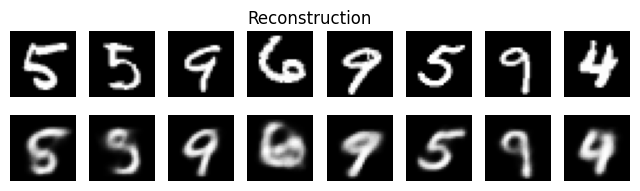

====> Test set loss: 127.5594


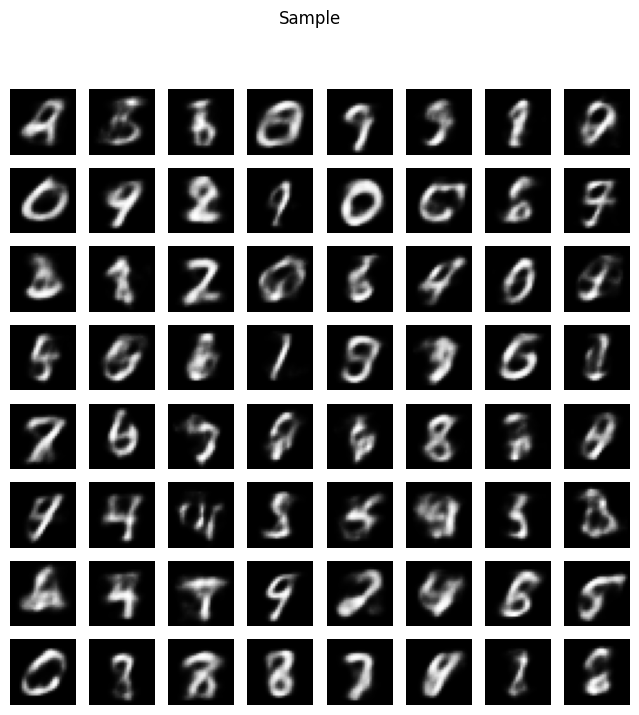

In [10]:
NUM_EPOCHS = 10
torch.manual_seed(0)

for epoch in range(1, NUM_EPOCHS + 1):
    train(epoch)
    test(epoch)
    with torch.no_grad():
        sample = np.random.binomial(1, 0.5, size=(64, 20))
        sample = torch.from_numpy(np.float32(sample)).to(device)
        sample = model.decode(sample).cpu()

        sample = sample.view(64, 1, 28, 28)

        fig, axes = plt.subplots(8, 8, figsize=(8, 8))
        for i, ax in enumerate(axes.flat):
            if i < 64:
                ax.imshow(sample[i].squeeze(), cmap='gray')
                ax.axis('off')
            else:
                ax.axis('off')

        fig.suptitle('Sample')
        plt.show()

We see that VAE has learned something adequate, which means that the reparameterization is happening correctly.
For the rest of the methods, vae are also implemented, which you can get engaged using scripts in the `demo` folder. Read more in `README.md`.
